KNN- ALGORITHM  IMPLEMENTATION FOR AMAZON DATASET
==============

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [ ]:
df2 = pd.read_csv('final_clean.csv')
df2.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [ ]:

X = df2['cleanedText'].values
Y = df2['Score']

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation

# split the data set into train and test
X_1, X_test, Y_1, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_2, X_cv, Y_2, Y_cv = cross_validation.train_test_split(X_1, Y_1, test_size=0.3)


K-fold cross validation
----------

1.   Indorder to do Cross validation we are splitting the dataset into two parts i.e) 70% of entire data is TRAININGDATA and 30 % is TESTDATA (used for dedicated crossvalidation).
2.    Split the dataset into k groups
2.  Take the group as a hold out or test data set

4.   Take the remaining groups as a training data set

5.   Fit a model on the training set and evaluate it on the test set

6.   Retain the evaluation score and discard the model

7.   Summarize the skill of the model using the sample of model evaluation scores
![](https://i.stack.imgur.com/fXZ6k.png)


 TIME SERIES  DATA WILL BE CROSSVALIDATED AS SHOWN IN ABOVE:--
 ---------------------






Dedicated Cross validation:
---------------
1. Leave-p-out cross-validation (LpO CV) involves using p observations as the validation set and the remaining observations as the training set
2. This is repeated on all ways to cut the original sample on a validation set of p observations and a training set.

*KNN with BAG OF WORDS * 
=====

In [ ]:
%%time
count_vect = CountVectorizer( )
train_BOW = count_vect.fit_transform(X_1)
train_BOW_CV = count_vect.transform(X_2)
test_BOW = count_vect.transform(X_test)

CPU times: user 18.2 s, sys: 457 ms, total: 18.6 s
Wall time: 18.7 s


In [ ]:
%%time
from sklearn.decomposition import TruncatedSVD
# initilaize the algorithm with some parameters..
# All of them are default except n_components. n_itr is for Randomized SVD solver.
trunc_svd = TruncatedSVD(n_components=500, algorithm='randomized', random_state=15)
#trunc_svd.fit(train_BOW)

CPU times: user 10.7 ms, sys: 146 µs, total: 10.8 ms
Wall time: 55.3 ms


In [ ]:
train_tsvd = trunc_svd.fit_transform(train_BOW)
train_CV   =trunc_svd.transform(train_BOW_CV)
test_tsvd = trunc_svd.transform(test_BOW)

In [ ]:
np.sum(trunc_svd.explained_variance_ratio_)

0.716397953200266

 Lets try 10 fold Cross-validation and Dedicated Cross-validation for both Bruteforce and KD-tree approach.
-----------------------------

In [ ]:
import time

def perform_3fold_brute(train_feat,y_train,test_feat,y_test):
    cv_scores=[]
    k =[]
    for i in range(1,20,2):
        knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
        scores = cross_val_score(knn,train_feat[0:30000],y_train[0:30000], cv=3, scoring='accuracy')
        cv_scores.append(scores.mean())
        k.append(i)
    MSE = [1-x for x in cv_scores]
    optimal_k = k[MSE.index(min(MSE))]
    print('\nThe best value of K using 3 fold CV:  %d.' % optimal_k)
    plt.plot(k,MSE)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    p= time.time()
    #plotting k vs misclassification error for obtaining mimimal error

    knn=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
    knn.fit(train_feat[0:30000],y_train[0:30000])
    predicted_val=knn.predict(train_feat[0:10000])
    result = accuracy_score(y_train[0:10000],predicted_val,normalize=True)*float(100)
    print("Accuracy on training set using bruteforce is: ",result)
    #evaluating training set
    predicted=knn.predict(test_feat[0:10000])
    resultant = accuracy_score(y_test[0:10000],predicted,normalize=True)*float(100)
    confusion = metrics.confusion_matrix(y_test[0:10000],predicted)
    print("Accuracy on test set is using bruteforce: ",resultant)
    print('<=======CONFUSION MATRIX OF TESTDATA======>')

    P= sns.heatmap(confusion, annot=True, fmt="d")
    plt.show()
    q = time.time()
    print('Time taken using brute force: {:.2f} '.format(1000*(q-p)),'millisecond')



In [ ]:
def perform_3fold_kdtree(train_feat,y_train,test_feat,y_test):
    cv_scores=[]
    k =[]
    for i in range(1,20,2):
        knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
        scores = cross_val_score(knn,train_feat[0:30000],y_train[0:30000], cv=3, scoring='accuracy')
        cv_scores.append(scores.mean())
        k.append(i)
    MSE = [1-x for x in cv_scores]
    optimal_k = k[MSE.index(min(MSE))]
    #hyperparameter tuning for optimal K

    print('\nThe best value of K using 3 fold CV:  %d.' % optimal_k)
    plt.plot(k,MSE)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    #plotting k vs misclassification error for obtaining mimimal error

    p= time.time()
    knn1=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
    knn1.fit(train_feat[0:30000],y_train[0:30000])
    predicted_val=knn1.predict(train_feat[0:10000])
    result = accuracy_score(y_train[0:10000],predicted_val,normalize=True)*float(100)
    print("Accuracy on training set using kdtree is: ",result)
    #evaluating training set
    predicted=knn1.predict(test_feat[0:10000])
    resultant = accuracy_score(y_test[0:10000],predicted,normalize=True)*float(100)
    confusion_ = confusion_matrix(y_test[0:10000],predicted)
    #evaluating test set
    print("Accuracy on test set using kdtree is: ",resultant)
    print('<=======CONFUSION MATRIX OF TESTDATA======>')
    L= sns.heatmap(confusion_, annot=True, fmt="d")
    plt.show  

    q= time.time()
    print('Time taken using kdtree: {:.2f} '.format(1000*(q-p)),'millisecond')

In [ ]:
def dedicatedcv_brute(train_feat,y_train,test_feat,y_cv,y_test):
    cv_scores=[]
    k =[]
    for i in range(1,20,2):
        knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
        knn.fit(train_feat[0:30000],y_train[0:30000])
        pred = knn.predict(test_feat[0:10000])
        score = accuracy_score(y_cv[0:10000],pred)
        cv_scores.append(score)
        k.append(i)
    MSE = [1-x for x in cv_scores]
    optimal_k = k[MSE.index(min(MSE))]
    print('\nThe best value of K:  %d.' % optimal_k)
    plt.plot(k,MSE)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    #hyperparameter tuning for optimal K

    p= time.time()
    knn=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
    knn.fit(train_feat[0:30000],y_train[0:30000])
    predicted_val=knn.predict(train_feat[0:10000])
    resultant = accuracy_score(y_train[0:10000],predicted_val,normalize=True)*float(100)
    print("Accuracy on training set using bruteforce is: ",resultant)
    #evaluating trainingset
    
    predicted=knn.predict(test_feat[0:10000])
    result = accuracy_score(y_test[0:10000],predicted,normalize=True)*float(100)
    confusion = confusion_matrix(y_test[0:10000],predicted)
    #evaluating testset
    print("Accuracy on test set using bruteforce is: ",result)
    print('<=======CONFUSION MATRIX OF TESTDATA======>')
    P= sns.heatmap(confusion, annot=True, fmt="d")
    plt.show()
    q = time.time()
    print('time taken using brute force: {:.2f} '.format(1000*(q-p)),'millisecond')

In [ ]:
def dedicatedcv_kdtree(train_feat,y_train,test_feat,y_cv,y_test):
    cv_scores=[]
    k =[]
    for i in range(1,20,2):
        knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
        knn.fit(train_feat[0:30000],y_train[0:30000])
        pred = knn.predict(test_feat[0:10000])
        score = accuracy_score(y_cv[0:10000],pred)
        cv_scores.append(score)
        k.append(i)
    MSE = [1-x for x in cv_scores]
    optimal_k = k[MSE.index(min(MSE))]
    print('\nThe best value of K:  %d.' % optimal_k)
    plt.plot(k,MSE)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    #hyperparameter tuning for optimal K

    p= time.time()
    knn=KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
    knn.fit(train_feat[0:30000],y_train[0:30000])
    predicted_val=knn.predict(train_feat[0:10000])
    resultant = accuracy_score(y_train[0:10000],predicted_val,normalize=True)*float(100)
    print("Accuracy on training set using kdtree is: ",resultant)
    #evaluating trainingset
    
    predicted=knn.predict(test_feat[0:10000])
    result = accuracy_score(y_test[0:10000],predicted,normalize=True)*float(100)
    confusion = confusion_matrix(y_test[0:10000],predicted)
    #evaluating testset
    print("Accuracy on test set using kdtree is: ",result)
    print('<=======CONFUSION MATRIX OF TESTDATA======>')
    P= sns.heatmap(confusion, annot=True, fmt="d")
    plt.show()
    q = time.time()
    print('Time taken using kdtree force: {:.2f} '.format(1000*(q-p)),'millisecond')


The best value of K using 3 fold CV:  11.


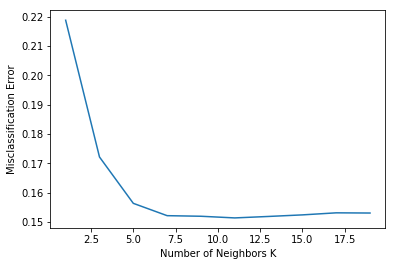

Accuracy on training set using bruteforce is:  85.81
Accuracy on test set is using bruteforce:  84.25
<=======CONFUSION MATRIX OF TESTDATA======>


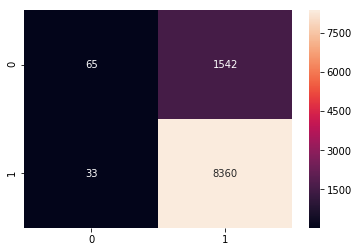

Time taken using brute force: 36977.65  millisecond


In [ ]:
BOW_3fold_brute=perform_3fold_brute(train_BOW,Y_1,test_BOW,Y_test)



The best value of K:  19.


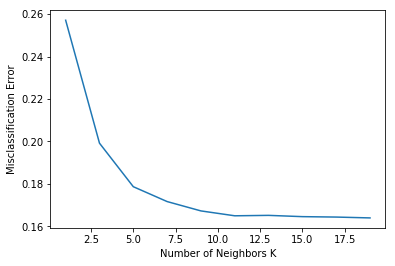

Accuracy on training set using bruteforce is:  84.54
Accuracy on test set using bruteforce is:  83.89999999999999
<=======CONFUSION MATRIX OF TESTDATA======>


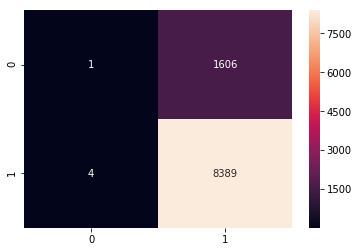

time taken using brute force: 36566.26  millisecond


In [ ]:
BOW_brute_CV=dedicatedcv_brute(train_BOW,Y_2,test_BOW,Y_cv,Y_test)


The best value of K using 3 fold CV:  15.


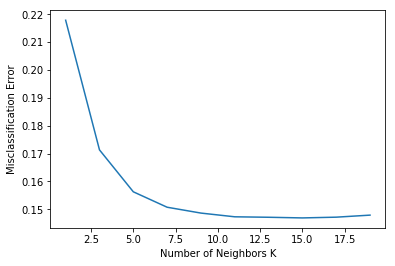

Accuracy on training set using kdtree is:  86.31
Accuracy on test set using kdtree is:  84.52
<=======CONFUSION MATRIX OF TESTDATA======>
Time taken using kdtree: 885097.55  millisecond


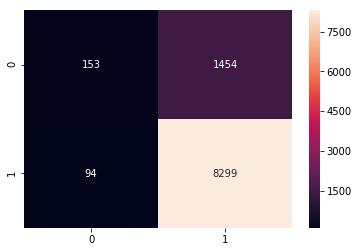

In [ ]:
BOW_kdtree_3fold=perform_3fold_kdtree(train_tsvd,Y_1,test_tsvd,Y_test)



The best value of K:  19.


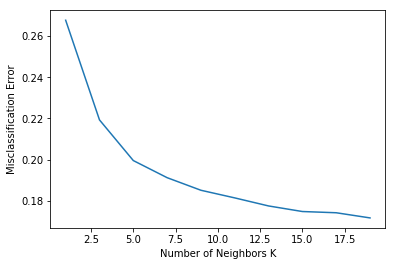

Accuracy on training set using kdtree is:  85.58
Accuracy on test set using kdtree is:  84.39999999999999
<=======CONFUSION MATRIX OF TESTDATA======>


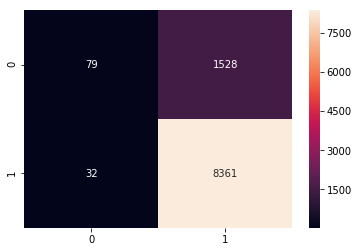

Time taken using brute force: 877968.43  millisecond


In [ ]:
BOW_kdtree_CV=dedicatedcv_kdtree(train_CV,Y_2,test_tsvd,Y_cv,Y_test)

*KNN ON BI-GRAMS*
====

In [ ]:
#featurization using bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
train_grams = count_vect.fit_transform(X_1)
test_grams = count_vect.transform(X_test)
cv_grams = count_vect.transform(X_2)

In [ ]:
#dimensionality reduction using truncated SVD for input to KDtree 
bigram_train = trunc_svd.fit_transform(train_grams)
bigram_CV   =trunc_svd.transform(cv_grams)
bigram_test = trunc_svd.transform(test_grams)


The best value of K using 3 fold CV:  19.


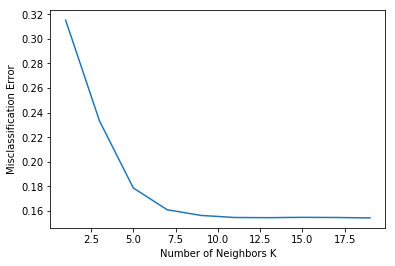

Accuracy on training set using bruteforce is:  84.63000000000001
Accuracy on test set is using bruteforce:  83.99
<=======CONFUSION MATRIX OF TESTDATA======>


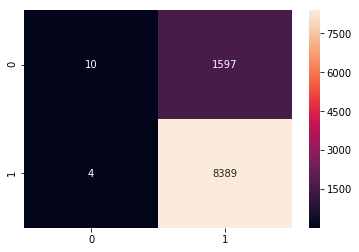

Time taken using brute force: 35842.09  millisecond


In [ ]:
bigrams_3fold_brute=perform_3fold_brute(train_grams,Y_1,test_grams,Y_test)


The best value of K:  19.


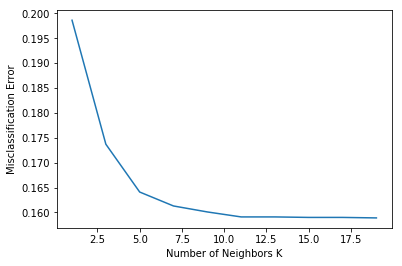

Accuracy on training set using bruteforce is:  84.48
Accuracy on test set using bruteforce is:  83.93
<=======CONFUSION MATRIX OF TESTDATA======>


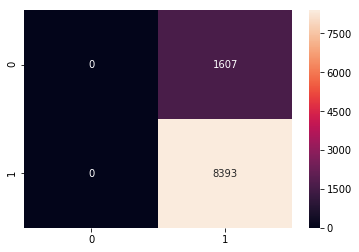

time taken using brute force: 39255.27  millisecond


In [ ]:
Bigrams_brute_CV=dedicatedcv_brute(train_grams,Y_2,test_grams,Y_cv,Y_test)


The best value of K using 3 fold CV:  13.


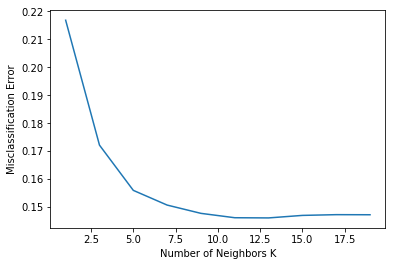

Accuracy on training set using kdtree is:  86.74
Accuracy on test set using kdtree is:  84.56
<=======CONFUSION MATRIX OF TESTDATA======>
Time taken using kdtree: 880528.32  millisecond


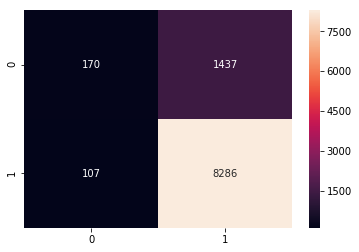

In [ ]:
Bigrams_kdtree_3fold=perform_3fold_kdtree(bigram_train,Y_1,bigram_test,Y_test)



The best value of K:  19.


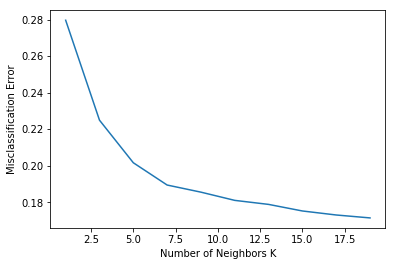

Accuracy on training set using kdtree is:  85.54
Accuracy on test set using kdtree is:  84.85000000000001
<=======CONFUSION MATRIX OF TESTDATA======>


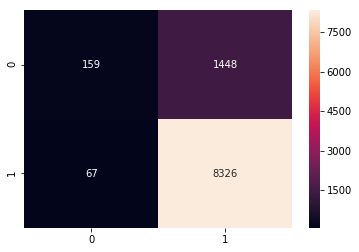

Time taken using kdtree force: 814789.29  millisecond


In [ ]:
Bigrams_kdtree_CV=dedicatedcv_kdtree(bigram_CV,Y_2,bigram_test,Y_cv,Y_test)

*KNN  with TF-IDF with 10 fold cross validation*
====

In [ ]:
tf_idf = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf.fit_transform(X_1)
tfidf_test = tf_idf.transform(X_test)
tfidf_cv=tf_idf.transform(X_2)

In [ ]:
train_tfidfsvd = trunc_svd.fit_transform(tfidf_train)


In [ ]:
CV_tfidfsvd   =trunc_svd.transform(tfidf_cv)
test_tfidfsvd = trunc_svd.transform(tfidf_test)


The best value of K using 3 fold CV:  9.


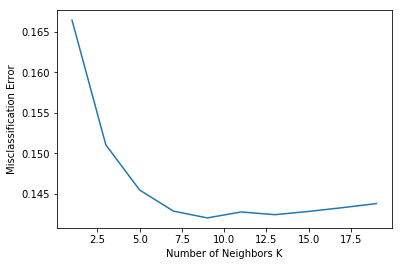

Accuracy on training set using bruteforce is:  86.68
Accuracy on test set is using bruteforce:  85.28
<=======CONFUSION MATRIX OF TESTDATA======>


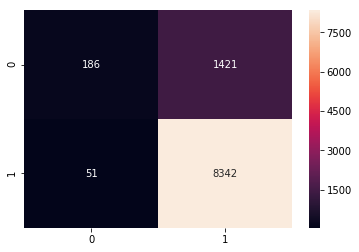

Time taken using brute force: 38709.37  millisecond


In [ ]:
TFIDF_3fold_brute=perform_3fold_brute(tfidf_train,Y_1,tfidf_test,Y_test)



The best value of K:  1.


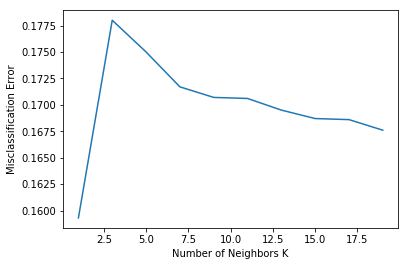

Accuracy on training set using bruteforce is:  100.0
Accuracy on test set using bruteforce is:  83.99
<=======CONFUSION MATRIX OF TESTDATA======>


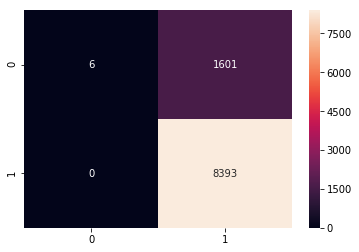

time taken using brute force: 34447.59  millisecond


In [ ]:
TFIDF_cv_brute=dedicatedcv_brute(tfidf_cv,Y_2,tfidf_test,Y_cv,Y_test)


The best value of K using 3 fold CV:  19.


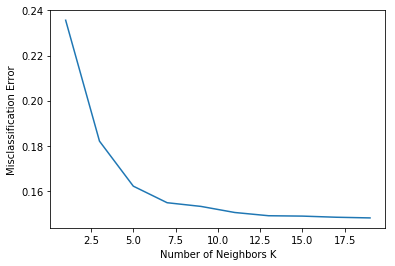

Accuracy on training set using kdtree is:  85.61
Accuracy on test set using kdtree is:  84.58
<=======CONFUSION MATRIX OF TESTDATA======>
Time taken using kdtree: 971334.79  millisecond


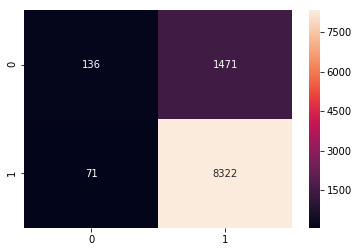

In [ ]:
TFIDF_3fold_kdtree=perform_3fold_kdtree(train_tfidfsvd,Y_1,test_tfidfsvd,Y_test)


The best value of K:  19.


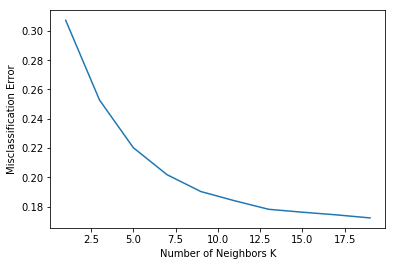

Accuracy on training set using kdtree is:  85.61
Accuracy on test set using kdtree is:  84.65
<=======CONFUSION MATRIX OF TESTDATA======>


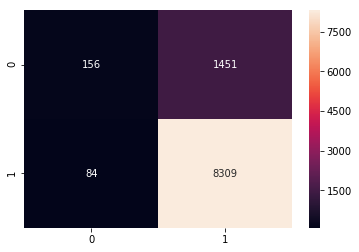

Time taken using kdtree force: 930275.44  millisecond


In [ ]:
TFIDF_cv_kdtree=dedicatedcv_kdtree(CV_tfidfsvd,Y_2,test_tfidfsvd,Y_cv,Y_test)

*KNN using WORD 2 VEC * with 10 fold cross validation
======
---

In [ ]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [ ]:
import re
i=0
list_of_sent=[]
for sent in X_1:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)


In [ ]:
i =0
list_of_Xtest =[]
for sent in X_test:
    final_Xtest = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                final_Xtest.append(cleaned_words.lower())
            else:
                continue
    list_of_Xtest.append(final_Xtest)

In [ ]:
i=0
list_of_sent_CV=[]
for sent in X_2:
    filtered=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_CV.append(filtered)


In [ ]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=3,size=50, workers=5)
#training models



In [ ]:
w2v_model1=gensim.models.Word2Vec(list_of_Xtest,min_count=3,size=50, workers=5)


In [ ]:
w2v_model2=gensim.models.Word2Vec(list_of_sent_CV,min_count=3,size=50, workers=5)


**AVERAGE WORD 2 VEC**
----

In [ ]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vect = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vect = w2v_model.wv[word]
            sent_vect += vect
            count_words += 1
        except:
            pass
    sent_vect /= count_words
    sent_vectors.append(sent_vect)


In [ ]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_Xtest: # for each review/sentence
    sent_vector = np.zeros(50) # as word vectors are of zero length
    cnt_word =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vector = w2v_model1.wv[word]
            sent_vector += vector
            cnt_word += 1
        except:
            pass
    sent_vector /= cnt_word
    sent_vectors_test.append(sent_vector)


In [ ]:
sent_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_CV: # for each review/sentence
    sent_vectors_cv = np.zeros(50) # as word vectors are of zero length
    ct_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vectors = w2v_model2.wv[word]
            sent_vectors_cv += vectors
            ct_words += 1
        except:
            pass
    sent_vectors_cv /= ct_words
    sent_cv.append(sent_vectors_cv)



The best value of K using 3 fold CV:  11.


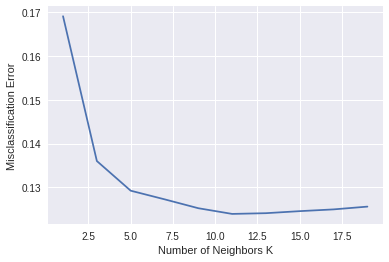

Accuracy on training set using bruteforce is:  89.29
Accuracy on test set is using bruteforce:  84.72
<=======CONFUSION MATRIX OF TESTDATA======>


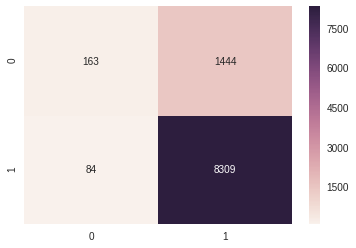

Time taken using brute force: 14005.76  millisecond


In [ ]:
avgw2v_3fold_brute=perform_3fold_brute(sent_vectors,Y_1,sent_vectors_test,Y_test)



The best value of K:  19.


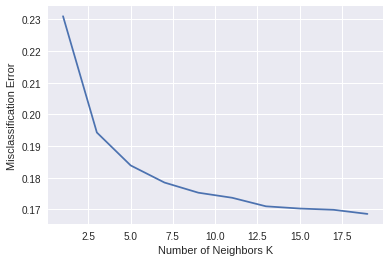

Accuracy on training set using bruteforce is:  87.52
Accuracy on test set using bruteforce is:  84.85000000000001
<=======CONFUSION MATRIX OF TESTDATA======>


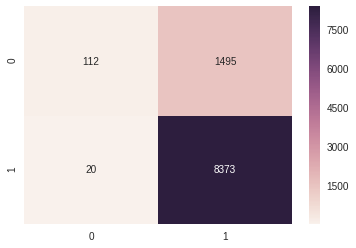

time taken using brute force: 15360.56  millisecond


In [ ]:
avgw2v_cv_brute=dedicatedcv_brute(sent_cv,Y_2,sent_vectors_test,Y_cv,Y_test)


The best value of K using 3 fold CV:  11.


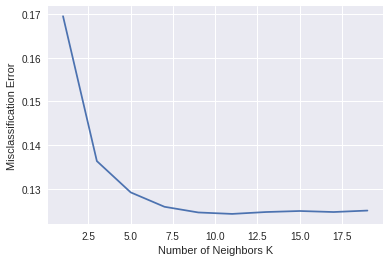

Accuracy on training set using kdtree is:  89.11
Accuracy on test set using kdtree is:  84.68
<=======CONFUSION MATRIX OF TESTDATA======>
Time taken using kdtree: 131495.03  millisecond


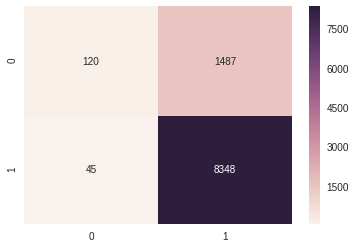

In [ ]:
w2v_3fold_kdtree=perform_3fold_kdtree(sent_vectors,Y_1,sent_vectors_test,Y_test)



The best value of K:  19.


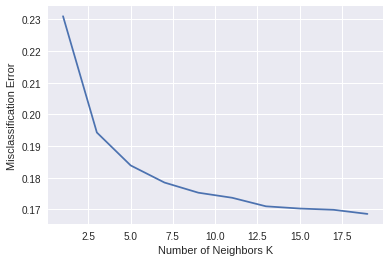

Accuracy on training set using kdtree is:  87.52
Accuracy on test set using kdtree is:  84.85000000000001
<=======CONFUSION MATRIX OF TESTDATA======>


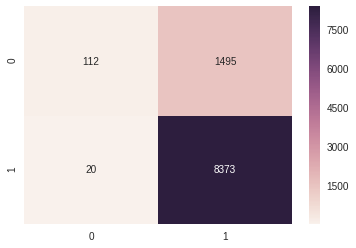

Time taken using kdtree force: 132981.53  millisecond


In [ ]:
w2v_cv_kdtree=dedicatedcv_kdtree(sent_cv,Y_2,sent_vectors_test,Y_cv,Y_test)

*TF-IDF WORD 2 VEC*
======

In [ ]:
tf_idf_vec = TfidfVectorizer()
tf_idf_tr = tf_idf_vec.fit_transform(X_1)


In [ ]:
# TF-IDF weighted Word2Vec

tfidf_feat = tf_idf_vec.get_feature_names() # tfidf words/col-names
# tf_idf_tr is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent[0:30000]: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf_w2v = tf_idf_tr[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf_w2v)
            weight_sum += tfidf_w2v
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
tf_idf_vectt = TfidfVectorizer()
test_tfidf = tf_idf_vectt.fit_transform(X_test)


In [ ]:
tfidf_features = tf_idf_vectt.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_Xtest[0:30000]: # for each review/sentence
    sent_vect = np.zeros(50) # as word vectors are of zero length
    weight_summ =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec1 = w2v_model1.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf_test = test_tfidf[row, tfidf_features.index(word)]
            sent_vect += (vec1 * tfidf_test)
            weight_summ += tfidf_test
        except:
            pass
    sent_vect /= weight_summ
    tfidf_sent_test.append(sent_vect)
    row += 1


In [ ]:
tf_idfcv = TfidfVectorizer()
cv_tfidf = tf_idfcv.fit_transform(X_2)


In [ ]:
tfidf_feature = tf_idfcv.get_feature_names() # tfidf words/col-names

tfidf_sent_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_CV[0:30000]: # for each review/sentence
    sent_vectors = np.zeros(50) # as word vectors are of zero length
    weight_sm =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec2 = w2v_model2.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf_cv  = cv_tfidf[row, tfidf_feature.index(word)]
            sent_vectors += (vec1 * tfidf_test)
            weight_sm += tfidf_cv
        except:
            pass
    sent_vectors /= weight_sm
    tfidf_sent_cv.append(sent_vectors)
    row += 1



The best value of K using 3 fold CV:  19.


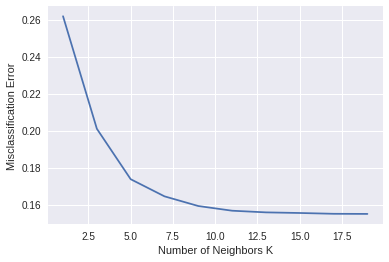

Accuracy on training set using bruteforce is:  84.54
Accuracy on test set is using bruteforce:  83.93
<=======CONFUSION MATRIX OF TESTDATA======>


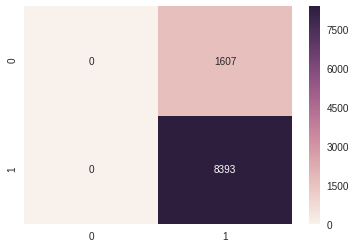

Time taken using brute force: 18270.16  millisecond


In [ ]:
tfidfw2v_3fold_brute=perform_3fold_brute(tfidf_sent_vectors,Y_1,tfidf_sent_test,Y_test)



The best value of K:  7.


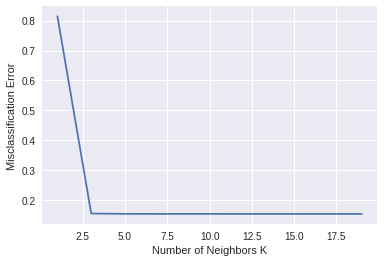

Accuracy on training set using bruteforce is:  84.57000000000001
Accuracy on test set using bruteforce is:  83.93
<=======CONFUSION MATRIX OF TESTDATA======>


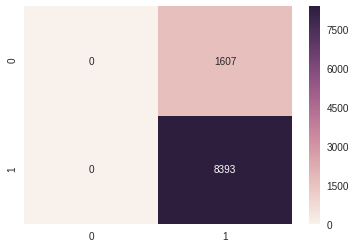

time taken using brute force: 15036.28  millisecond


In [ ]:
tfidfw2v_cv_brute=dedicatedcv_brute(tfidf_sent_cv,Y_2,tfidf_sent_test,Y_cv,Y_test)


The best value of K using 3 fold CV:  19.


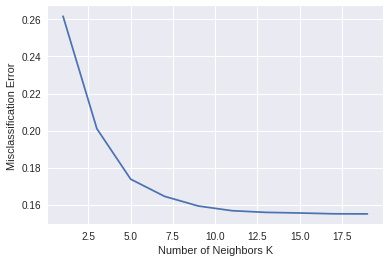

Accuracy on training set using kdtree is:  84.54
Accuracy on test set using kdtree is:  83.93
<=======CONFUSION MATRIX OF TESTDATA======>
Time taken using kdtree: 906.21  millisecond


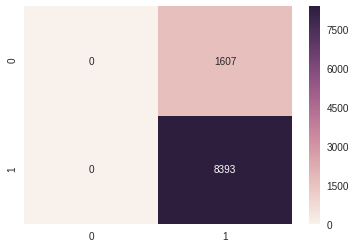

In [ ]:
tfidfw2v_3fold_kdtree=perform_3fold_kdtree(tfidf_sent_vectors,Y_1,tfidf_sent_test,Y_test)



The best value of K:  7.


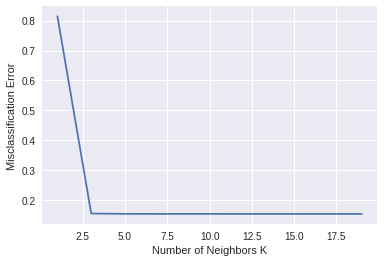

Accuracy on training set using kdtree is:  84.57000000000001
Accuracy on test set using kdtree is:  83.93
<=======CONFUSION MATRIX OF TESTDATA======>


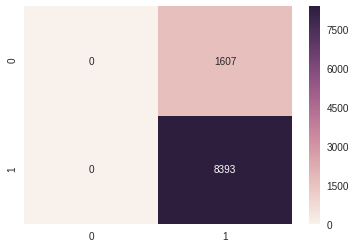

Time taken using kdtree force: 957.43  millisecond


In [ ]:
tfidfw2v_cv_kdtree=dedicatedcv_kdtree(tfidf_sent_cv,Y_2,tfidf_sent_test,Y_cv,Y_test)


 Conclusion:
 ----

1.   Converting each review into vector                                                            
2.    Finding the right K using 3-fold cross validation                                                                                 
1. Finding the right K using dedicated cross validation                                                                     

4. Applying Knn on test data using   brute force algorithm and calculating Accuracy  and printing confusion matrix                 
 
 
 5. Applying knn on test data using kd_tree algorithm and calculating Accuracy  and printing confusion matrix                                
 7. Obtaining performance over training data






 



In [ ]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Featurization","BOW","BIGRAMS","TFIDF","AVG_W2V","TFIDF_W2V"	]
x.add_row(["Optimal K by 3 fold CV using Bruteforce", 11, 19, 9,11,19])
x.add_row(["Train Accuracy", 85.81, 84.63, 86.68,89.29,84.54])
x.add_row(["Test Accuracy", 84.25, 83.99, 85.28,84.72,83.93])
x.add_row(["----------------------------------------------","------","------", "-------","------","-------"])

x.add_row(["Optimal K by 3 fold CV using KD-tree", 15, 13, 6,11,19])
x.add_row(["Train Accuracy", 86.31, 86.74, 85.61,89.11,84.54])
x.add_row(["Test Accuracy", 84.52, 84.56, 84.58,84.68,83.93])
x.add_row(["----------------------------------------------","------","-------" ,"-------","------","-------"])

x.add_row(["Optimal K by dedicated CV using Bruteforce", 19, 19, 1,19,7])
x.add_row(["Train Accuracy", 84.54, 84.48, 100,87.52,84.57])
x.add_row(["Test Accuracy", 83.89, 83.93, 83.99,84.85,83.93])
x.add_row(["----------------------------------------------","------","--------" ,"-------","-------","------"])

x.add_row(["Optimal K by dedicated CV using KD-tree", 19, 19, 13,19,7])
x.add_row(["Train Accuracy", 85.58, 85.54, 85.61,87.52,84.57])
x.add_row(["Test Accuracy", 84.39,84.45 , 84.65,84.85,83.93])



In [ ]:
print('Summary of featuriztions and optimal parameters with train and test accuracy')
print(x)

Summary of featuriztions and optimal parameters with train and test accuracy
+------------------------------------------------+--------+----------+---------+---------+-----------+
|                 Featurization                  |  BOW   | BIGRAMS  |  TFIDF  | AVG_W2V | TFIDF_W2V |
+------------------------------------------------+--------+----------+---------+---------+-----------+
|    Optimal K by 3 fold CV using Bruteforce     |   11   |    19    |    9    |    11   |     19    |
|                 Train Accuracy                 | 85.81  |  84.63   |  86.68  |  89.29  |   84.54   |
|                 Test Accuracy                  | 84.25  |  83.99   |  85.28  |  84.72  |   83.93   |
| ---------------------------------------------- | ------ |  ------  | ------- |  ------ |  -------  |
|      Optimal K by 3 fold CV using KD-tree      |   15   |    13    |    6    |    11   |     19    |
|                 Train Accuracy                 | 86.31  |  86.74   |  85.61  |  89.11  |   84.54 